 (sourced from [Yahoo! Finance](http://finance.yahoo.com/quote/JPM/history?p=JPM)).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

# Load your dataset
# Replace 'your_dataset.csv' with your actual file name
df = pd.read_csv('/kaggle/input/datasetjp/JPM.csv')

# Assuming your date column is named 'date', convert it to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Find the start and end dates
start_date = df['Date'].min()
end_date = df['Date'].max()

print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")


Start Date: 2000-01-03 00:00:00
End Date: 2023-08-08 00:00:00


In [3]:
## load dataset

data = pd.read_csv('/kaggle/input/datasetjp/JPM.csv', usecols=['Date','Open'])
data.head()

,Date,Open
0,2000-01-03,49.833332
1,2000-01-04,47.083332
2,2000-01-05,46.833332
3,2000-01-06,46.750000
4,2000-01-07,48.416668


In [4]:
## null value check

data.isnull().sum()

Date    0
Open    0
dtype: int64

In [5]:
## convert 'Date'--> datetime and set as index

data['Date'] = data['Date'].apply(lambda str_date: pd.to_datetime(str_date))

data.set_index('Date', inplace=True)

data.head()

,Open
Date,
2000-01-03,49.833332
2000-01-04,47.083332
2000-01-05,46.833332
2000-01-06,46.750000
2000-01-07,48.416668


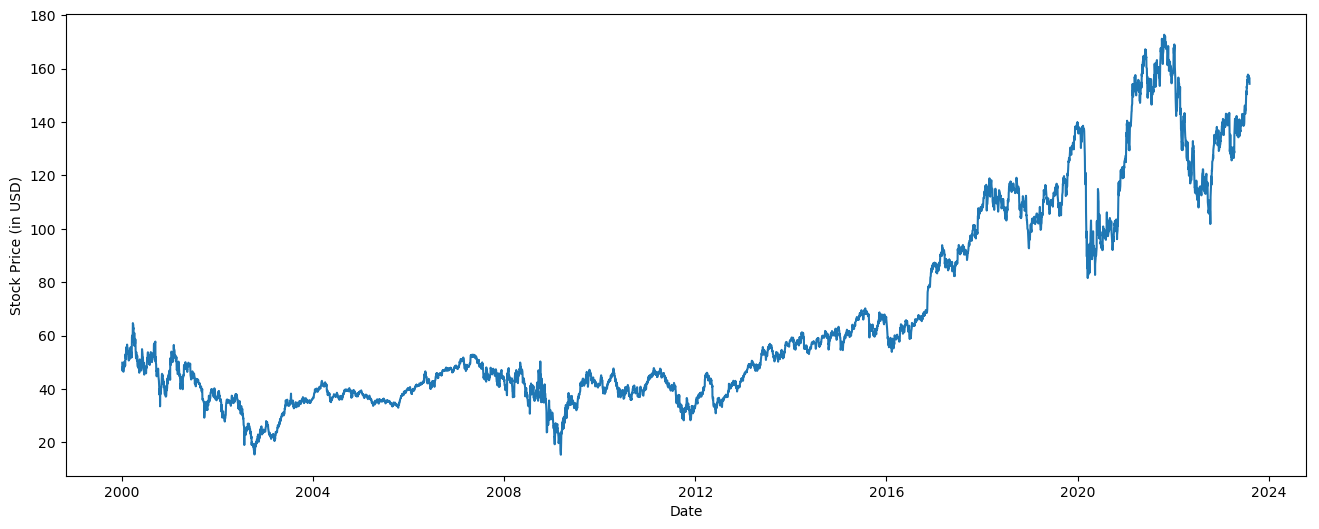

In [5]:
## visualizing data

fig = plt.figure(figsize=(16,6))

plt.plot(data['Open'])
plt.xlabel('Date')
plt.ylabel('Stock Price (in USD)')

plt.show()

In [6]:
## train test split

train = data[data.index < pd.to_datetime('01-01-2018')]
test = data[data.index >= pd.to_datetime('01-01-2018')]

In [7]:
train.shape

(4528, 1)

In [8]:
test.shape

(1409, 1)

In [8]:
## data normalization

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

In [10]:
train[:10]

array([[0.37125211],
       [0.34162806],
       [0.33893497],
       [0.33803728],
       [0.35599126],
       [0.35688895],
       [0.3371396 ],
       [0.33489532],
       [0.34521888],
       [0.3654171 ]])

In [11]:
test[:10]

array([[0.99385974],
       [0.99633743],
       [1.00172362],
       [1.01141878],
       [0.99946143],
       [1.00560168],
       [1.01368097],
       [1.02660779],
       [1.03716476],
       [1.03565663]])

In [12]:
## convert data into proper format

time_steps = 60

def convert(data, time_steps):
    
    X = list()
    
    for i in range(time_steps, len(data)):
        
        obs = data[i-time_steps:i,0].reshape(time_steps) ## observations
        
        X.append(obs)
        
    X = np.array(X)
    
    X = np.reshape(X, (X.shape[0],X.shape[1],1))
    
    return X

In [13]:
X_train = convert(data=train, time_steps=time_steps)
X_test = convert(data=test, time_steps=time_steps)

In [14]:
X_train.shape

(4468, 60, 1)

In [15]:
X_test.shape

(1349, 60, 1)

In [16]:
## imports

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from keras.optimizers import Adam

In [17]:
model = Sequential() ## initialization

model.add(LSTM(units=3*X_train.shape[1], activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.5)) ## 30% perceptrons turned off at every pass
## output_shape --> (batch_size, 3*X_train.shape[1])
model.add(RepeatVector(n=X_train.shape[1]))
## output_shape --> (batch_size, 3*X_train.shape[1], X_train.shape[1])
model.add(LSTM(units=3*X_train.shape[1], activation='tanh', return_sequences=True))
model.add(Dropout(rate=0.5)) ## 30% perceptrons turned off at every pass
## output_shape --> (batch_size, 3*X_train.shape[1], X_train.shape[1])
model.add(TimeDistributed(Dense(units=X_train.shape[2])))
## output_shape --> (batch_size, 3*X_train.shape[1], 1) --> SAME AS INPUT (AUTOENCODER CONCEPT)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 180)            │       131,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 60, 180)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 180)        │       259,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 180)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 60, 1)          │           181 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,141 (1.49 MB)

 Trainable params: 391,141 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
## training

history = model.fit(x=X_train,
                   y=X_train,
                   batch_size=64,
                   epochs=100,
                   validation_split=0.1,
                   shuffle=False)

## notice how X_train is both the input and the target

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0252 - val_loss: 0.0126
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0051 - val_loss: 0.0140
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0055 - val_loss: 0.0140
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0056 - val_loss: 0.0098
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0061 - val_loss: 0.0077
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0089 - val_loss: 0.0079
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0106 - val_loss: 0.0083
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0088 - val_loss: 0.0139
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0104 - val_loss: 0.0084
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0083 - val_loss: 0.0078
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

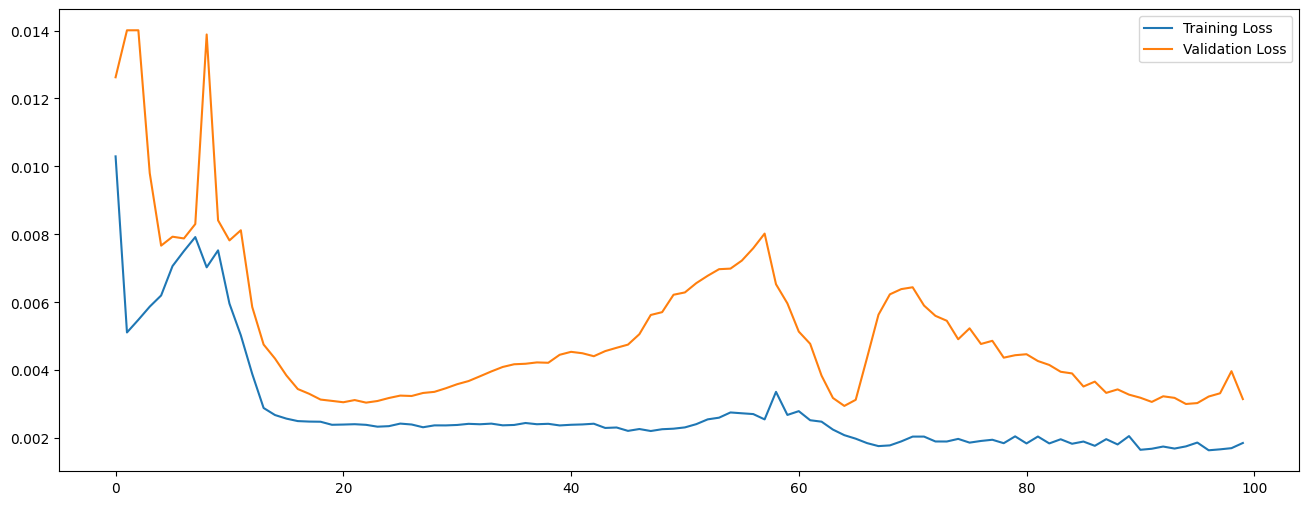

In [19]:
## plot loss over epochs

fig = plt.figure(figsize=(16,6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.show()

140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


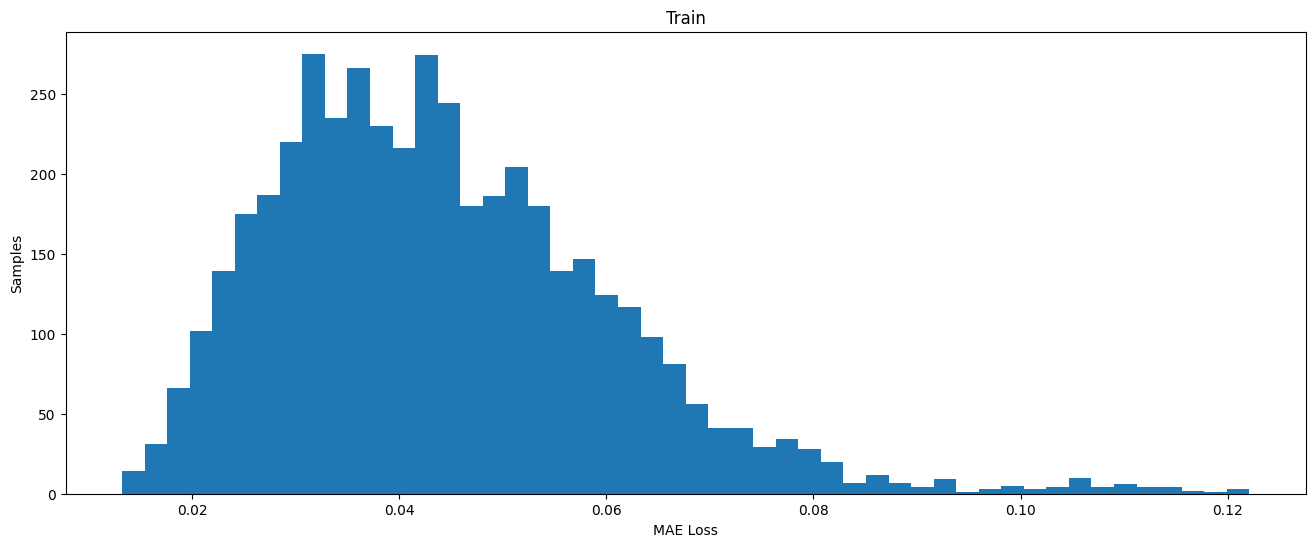

In [20]:
## mean absolute error loss across samples

train_mae_loss = np.mean(np.abs(model.predict(X_train)-X_train), axis=1)

## histogram of mean absolute error

fig = plt.figure(figsize=(16,6))

plt.hist(train_mae_loss, bins=50)
plt.title('Train')
plt.xlabel('MAE Loss')
plt.ylabel('Samples')

plt.show()

In [21]:
threshold = np.max(train_mae_loss) ## this is the max error that our model produced while reconstructing an input
threshold

0.12207791321223009

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


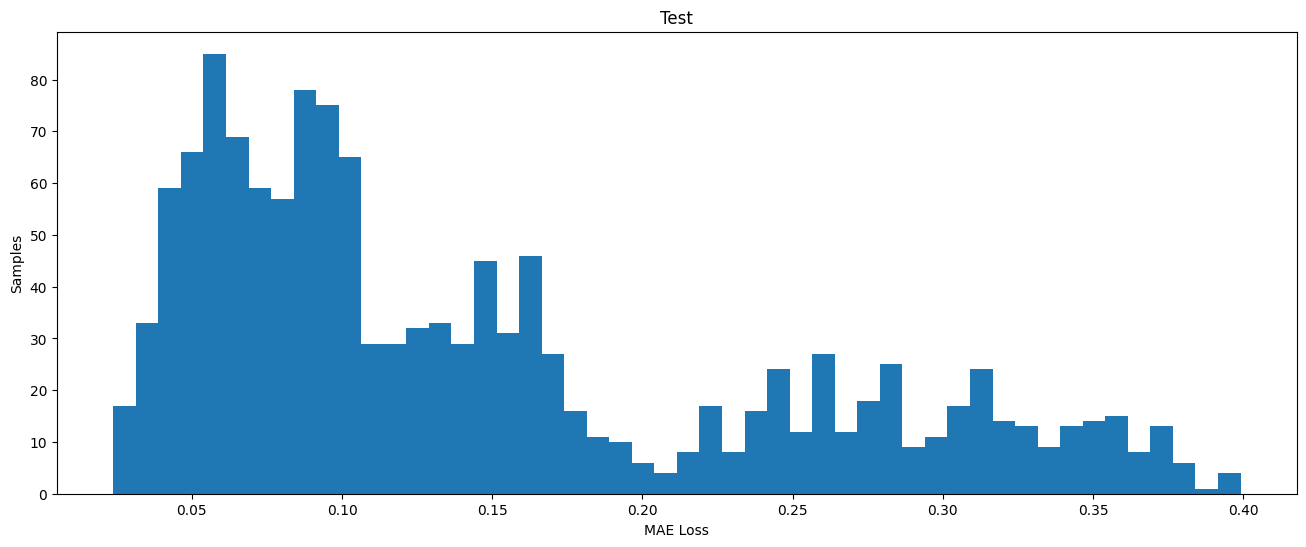

In [22]:
## test mae loss
test_mae_loss = np.mean(np.abs(model.predict(X_test)-X_test), axis=1)

## histogram of mean absolute error

fig = plt.figure(figsize=(16,6))

plt.hist(test_mae_loss, bins=50)
plt.title('Test')
plt.xlabel('MAE Loss')
plt.ylabel('Samples')

plt.show()

In [23]:
anomalies = test_mae_loss > threshold

anomalous_data_indices = [] ## indices of test observations that represent anomalies

for data_idx in range(time_steps - 1, len(test) - time_steps + 1):
    
    if np.all(anomalies[data_idx - time_steps + 1 : data_idx]):
        
        anomalous_data_indices.append(data_idx)

Refer [this]("https://keras.io/examples/timeseries/timeseries_anomaly_detection/") to understand above code.

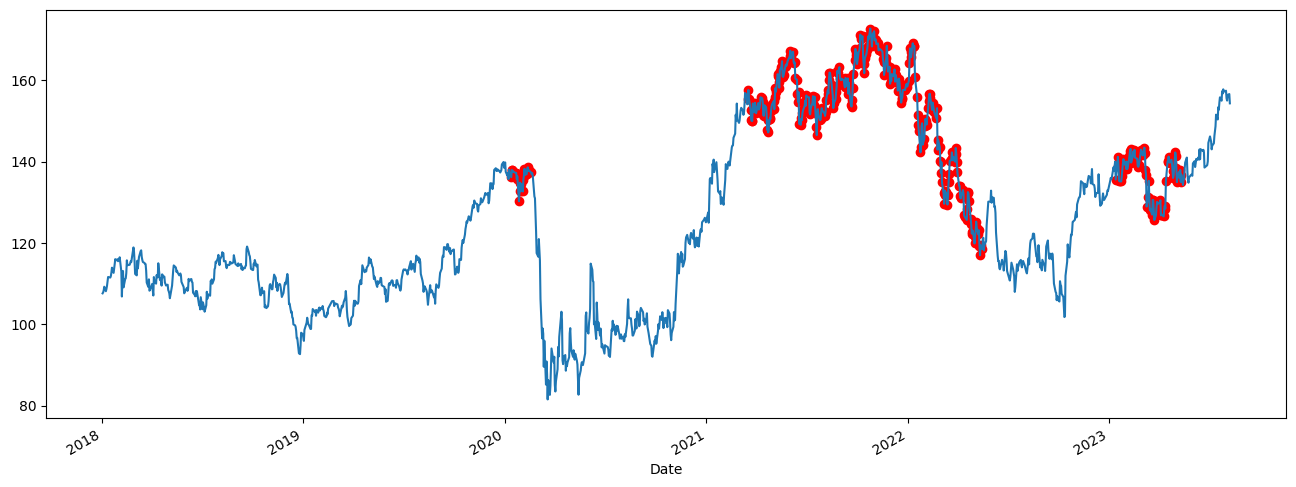

In [24]:
## reconstruction

test = scaler.inverse_transform(test)

reconstruct = pd.DataFrame(data=test, index=data.index[len(data)-len(test):], columns=['Open'])

test_anomalies = reconstruct.iloc[anomalous_data_indices]

fig, ax = plt.subplots(figsize=(16,6))

reconstruct.plot(legend=False, ax=ax)

ax.scatter(x=test_anomalies.index, y=test_anomalies['Open'], color="r")

plt.show()

**Important**: the red dot represent anomalies in the test set. 

In [26]:
## save model

from keras.models import save_model
save_model(model, 'LSTM_Autoencoder_timesteps60_epochs100_batchsize64.h5')